In [2]:
"""
Code for accommodating the graph-making need of ECON 3229-2 Money, Banking, and Financial Systems 

University of Missouri-Columbia

Fangda Wang

Fall 2017


https://github.com/vitanova
"""

# This file is aimed to demonstate the usefulness of the code I wrote before
# I changed several parameters in about 1 min or 2, and a new graph is plotted as required

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

#this is a third-party api for manipulating fred data
from fred import Fred

#first, use the api key to get access to fred, all data in dictionary format
fr = Fred(api_key='abcdefghijklmnopqrstuvwxyz123456', response_type='dict') ## <--- replacing with your own key

#now, use the series id to get observations
cpi=fr.series.observations(series_id="PCEPI") ## <--- make change: series_id
aaa=fr.series.observations(series_id="MICH") ## <--- make change
nber=fr.series.observations(series_id="USREC") ## <--- make change

#convert the dictionary data to data frame
CPI=pd.DataFrame.from_dict(cpi)
AAA=pd.DataFrame.from_dict(aaa)
NBER=pd.DataFrame.from_dict(nber)

#rename columns
CPI.columns = 'date', 'end', 'start', 'cpi' ## <--- make change: series_name
AAA.columns = 'date', 'end', 'start', 'mich' ## <--- make change
NBER.columns = 'date', 'end', 'start', 'nber'## <--- make change

#merge the two tables and use date as key
al=pd.merge(CPI, AAA, how='left', on='date')
al=pd.merge(al, NBER, how='left', on='date')
al=al.drop('end_x', axis=1)
al=al.drop('start_x', axis=1)
al=al.drop('end_y', axis=1)
al=al.drop('start_y', axis=1)
al=al.drop('end', axis=1)
al=al.drop('start', axis=1)

al.head()

C:\Anaconda3\lib\site-packages\fred\helpers\__init__.py:36: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  frame = frame.convert_objects(convert_numeric=True)
C:\Anaconda3\lib\site-packages\pandas\core\internals.py:3224: FutureWarning: Passing in 'datetime64' dtype with no frequency is deprecated and will raise in a future version. Please pass in 'datetime64[ns]' instead.
  return self.apply('astype', dtype=dtype, **kwargs)


,date,cpi,mich,nber
0,1959-01-01,17.124,NaN,0
1,1959-02-01,17.138,NaN,0
2,1959-03-01,17.149,NaN,0
3,1959-04-01,17.183,NaN,0
4,1959-05-01,17.191,NaN,0


In [3]:
#to reflect the up-to-date nature of data, we set end date as last available month in fred
#actually, we need data from 1977-07-01, but inflation rate need to be calculated based on last year
#so we get cpi data from 1976
start_date=datetime.date(1976, 7, 1) ## <--- make change: series_start_date
end_date=datetime.date(2017, 7, 1) ## <--- make change: series_end_date

#since we only plot quarterly data, these monthly observations should be transformed in frequency
index = pd.date_range(start=start_date, end=end_date, freq='3MS')
columns = ['A']
def diff_quarter(d1, d2):
    return (d2.year - d1.year) * 4 + int((d2.month - d1.month)/3)
n_rows=diff_quarter(start_date, end_date) + 1
data = np.array([np.arange(n_rows)]*1).T
df = pd.DataFrame(data, index=index, columns=columns)
df['date']=df.index

#now, use the quarterly format table to extract information from the fred data
new_one=pd.merge(df, al, how='left', on='date')
new_one=new_one.drop('A', axis=1)
new_one.head()

,date,cpi,mich,nber
0,1976-07-01,32.014,NaN,0
1,1976-10-01,32.541,NaN,0
2,1977-01-01,33.058,NaN,0
3,1977-04-01,33.678,NaN,0
4,1977-07-01,34.216,NaN,0


In [4]:
#add a new column to represent inflation rate, calculated by:
#     pi_t = (p_{t+4}-p_t)/p_t * 100%
# here t is quarterly data, so we add four as a whole year
#WARNING: we should check whether there is missing data for some dates
new_one['shifted_cpi']=new_one.cpi.shift(4)

def infl_rate(x, y):
    return (x-y)/y *100
new_one['inflation']=new_one.apply(lambda row: infl_rate(row['cpi'], row['shifted_cpi']), axis=1)
new_one.set_index('date') ## <--- make change: maybe use other functions instead

#transform date format from yyyy-mm-dd to yyyy Qq
def tran_date(xx):
    return str(xx.year) + " Q" + str(1+int(xx.month/3))
new_one['new_date']=new_one.apply(lambda row: tran_date(row['date']), axis=1)
t=new_one.drop(new_one.index[0:4])  ## <--- make change: maybe drop other rows instead


#add the zero line, prep two nber series to facilitate making the shaded area between them
t['zero']=0
t['+nber']=20*t['nber'] ## <--- make change: the value of multiplier should be greater than maximum of other series
t['-nber']=-t['+nber']
t['shifted_inflation']=t.inflation.shift(-4) ## <--- make change: new variable defining
t.head()

,date,cpi,mich,nber,shifted_cpi,inflation,new_date,zero,+nber,-nber,shifted_inflation
4,1977-07-01,34.216,NaN,0,32.014,6.878241,1977 Q3,0,0,0,7.005495
5,1977-10-01,34.668,NaN,0,32.541,6.536370,1977 Q4,0,0,0,7.597785
6,1978-01-01,35.251,5.2,0,33.058,6.633795,1978 Q1,0,0,0,7.716093
7,1978-04-01,35.919,6.7,0,33.678,6.654196,1978 Q2,0,0,0,8.218492
8,1978-07-01,36.613,6.6,0,34.216,7.005495,1978 Q3,0,0,0,8.964029


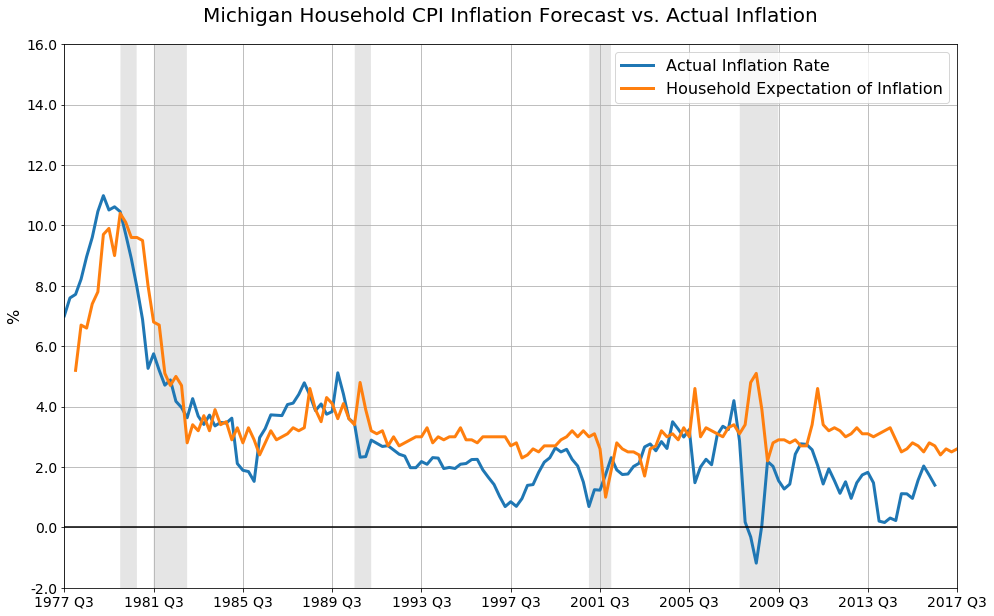

In [5]:
#since fill_between mathod doesnt work well with datetype64, we need to transform it
finally_=t.date.values
fig, ax=plt.subplots(figsize=(16, 10))
ax.plot(finally_, t['shifted_inflation'], label='Actual Inflation Rate', linewidth=3) ## <--- make change: series_name, series_label
ax.plot(finally_, t['mich'], label='Household Expectation of Inflation', linewidth=3) ## <--- make change
ax.plot(finally_, t['zero'], color='black', label='_nolegend_')

#transform the shaded area into rectangle
import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(finally_, t['+nber'], t['-nber'], facecolor='gray', interpolate=False, transform=trans, alpha=0.2)

#set the horizontal label as transformed data type
ax.set_xlim([t.date[t.index[0]], t.date[t.index[-1]]])
real_date=[]
trans_date=[]
for i in range(11): ## <--- make change: date displayed in the horizontal axis may vary
    real_date.append(t.date[t.index[16*i]])
    trans_date.append(t.new_date[t.index[16*i]])
ax.set_xticks(real_date)
ax.set_xticklabels(trans_date, fontsize=14)

ax.set_yticklabels(np.linspace(-2, 16, 10), fontsize=14)
ax.grid()
ax.set_ylim(-2, 16)
ax.set_ylabel("%", fontsize=16)
ax.legend(loc='best', fontsize=16)
ax.set_title("Michigan Household CPI Inflation Forecast vs. Actual Inflation", fontsize=20, position=[.5, 1.03])
## <--- make change: graph title
plt.show()